##  Budget in MITgcm. Part III: Momentum budget
**17 Nov 2019 by MiniUFO**

---
[TOC]

---
### 1. Introduction
As Part III of a series of notebook here we will do momentum budget using the model of [MITgcm](http://mitgcm.org/), and its related [python](https://www.python.org/) analysis package like [xmitgcm](https://github.com/xgcm/xmitgcm) and [xgcm](https://github.com/xgcm/xgcm).  It will show that the budget diagnostics are very convenient under the help of these packages.  However, momentum budget is somewhat complicated than previous heat/salt (Part I and II) budget.

---

### 2. Theoretical guide
###### 2.1 General equation for the momentum
The oceanic fluid simulated by MITgcm is driven by wind stress and buoyancy forcings.  These forcings exsert their effects at the surface and their energy input is eventually dissipated by visous or radiative processes.

For the momentum budget equation, the hydrostatic zonal momentum ($u$) equation in [flux-form](https://mitgcm.readthedocs.io/en/latest/algorithm/algorithm.html#flux-form-momentum-equations) reads:
>$$\frac{\partial u}{\partial t}=-\frac{1}{\rho_0}\frac{\partial p}{\partial x}-\mathbf u\cdot \nabla u+fv+\frac{uv\tan\phi}{a}+\nu\nabla^2u+F_x \tag{1}$$

where the terms on the rhs are the pressure gradient (PGF),  advection, Coriolis force, metric term, dissipation, and the external forcing, respectively.  Note that there could be some metric terms if the coordinate is not Cartesian.

For the [vector-invariant form](https://mitgcm.readthedocs.io/en/latest/algorithm/algorithm.html#vector-invariant-momentum-equations), the momentum equation reads:
>$$\frac{\partial \mathbf u}{\partial t}+(2\mathbf \Omega+\mathbf \zeta)\times\mathbf u-b\mathbf r+\nabla B=\nabla \cdot \mathbf \tau \tag{2}$$

In this form, the Coriolis force and metric terms will be absorbed into the advection term (the 2nd term on the lhs).


###### 2.2 Pressure gradient terms
In MITgcm, the pressure gradient term is splitted into [three parts](https://mitgcm.readthedocs.io/en/latest/overview/hydrostatic.html): the surface, hydrostatic and nonhydrostatic terms:
>$$PGF=-g\frac{\partial \eta}{\partial x}-\frac{1}{\rho_0}\frac{\partial p_{hyd}}{\partial x}-\frac{1}{\rho_0}\frac{\partial p_{nh}}{\partial x} \tag{3}$$

Notice that if your forcing includes Atmospheric pressure loading (```=atmP_load```), this contribution (```=-gradient```) needs to be added:
**```-1/rhoConst * (atmP_load(i) - atmP_load(i-1)) / DXC```**
 and the same thing applies to seaice-loading:
**```-gravity/rhoConst * (sIceLoad(i) - sIceLoad(i-1)) / DXC```**
The fixed density to use is "```rhoConst```" and not "```rhoConstFresh```"

###### 2.3 Advection and Coriolis terms
Notice that for the flux-form momentum equations, the advection and Coriolis terms are separated only if ```useCDscheme=TRUE``` .  In vector-invariant momentum equation, the advection and Coriolis terms are also summed up into a single (advection) term.  Note that the 3D Coriolis terms (in ```u``` and ```w``` equations) is now added to the ```Um_Advec```/```Vm_Advec``` and cannot be diagnosed separately.

###### 2.4 Dissipation terms
The dissipation of momentum is splitted into lateral and vertical terms.  The dissipation also includes both explicit and implicit parts.  If ```implicitVisocity=TRUE```, one has to calculate the implicit part (```VISrI_Um```/```VISrI_Vm```) oneself and add it to the total dissipation.  Therefore, the dissipation is defined as the 3D divergence of viscous stresses (or fluxes) that are explicit.  The viscous stresses includes harmonic and also biharmonic components, as well as the bottom and side drag effects near the boundaries.  Please see the [document](https://mitgcm.readthedocs.io/en/latest/algorithm/algorithm.html#lateral-dissipation) for more details.

###### 2.6 Metric terms
Metric terms refer to the contributions arised from non-Cartesian coordinate, such as the spherical terms near the Poles.  It is already included in the ```Um_Advec```/```Vm_Advec```, both [vector-invariant form](https://mitgcm.readthedocs.io/en/latest/algorithm/algorithm.html#vector-invariant-momentum-equations) and [flux-form](https://mitgcm.readthedocs.io/en/latest/algorithm/algorithm.html#flux-form-momentum-equations).

###### 2.5 External forcings
External forcing includes the surface wind stress and lateral or bottom frictions.

---

### 3. Practice using xgcm/xmitgcm
According to the above, the u-tendency (utdc) budget equation is:

**total_utdc = + Um_dPHdx + Um_dNHPdx - gravity * (ETAN(i)-ETAN(i-1)) / DXC**

**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;= + Um_Advec (+Um_Cori only if using CD_Scheme)**

**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;= + Um_Diss (+Implicit vertical viscosity tendency)**

**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;= + Um_Ext**

**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;= + AB_gU**

The MITgcm output diagnostics required for the heat budget are:

| Names in Python |  Outpus required by MITgcm  | Description |
| --------------------: | --------------------------------- | ------------- |
|  total_Utdc | ```TOTUTEND``` | total tendency of zonal momentum |
| prGrd_Utdc | ```Um_dPHdx```, ```Um_dNPHdx```, ```ETAN``` | tendency due to pressure gradient |
| advct_Utdc | ```Um_Advec``` | tendency due to advection, including Coriolis contribution if CD_Scheme is not used. Otherwise one need to add Coriolis contribution. |
| Corio_Utdc | ```Um_Cori``` | tendency due to Coriolis force  if CD_Scheme is used. Otherwise it is already added to Um_Advec. |
|  dissi_Utdc | ```Um_Diss```   | tendency due to dissipation, the 3D divergence of visous stresses as well as side and bottom drags |
|  VISrI_Utdc | ```VISrI_Um```   | tendency due to implicit vertical viscosity |
|  Exfrc_Utdc | ```Um_Ext```    | tendency due to external forcing |
| ABInt_Utdc | ```AB_gU```    |  tendency due to Adams-Bashforth integrator |

One can find these names in available_diagnosis.log generated in the run directory and set them in data.diagnostics for output.
One can find these names in available_diagnosis.log generated in the run directory and set them in data.diagnostics for output.  Then we start the budget analysis using [python](https://www.python.org/) and related packages.

First, we define a budget class in Python code as:


In [1]:
'''
Created on 2019.11.18

@author: MiniUFO, Wendy
Copyright 2018. All rights reserved. Use is subject to license terms.
'''
import matplotlib.pyplot as plt
import xmitgcm
import xgcm
import xarray as xr


class MomBudget(object):
    '''
    This class is designed for the momentum budget analysis in MITgcm.
    '''
    def __init__(self, dset):
        '''
        Construct a MomBudget instance using a Dataset
        
        Parameters
        ----------
        dset : xarray.Dataset
            a given Dataset containing MITgcm output diagnostics
        
        Return
        ----------
        terms : xarray.Dataset
            A Dataset containing all budget terms
        '''
        self.grid   = xgcm.Grid(dset)
        self.coords = dset.coords.to_dataset().reset_coords()
        self.dset   = dset.reset_coords(drop=True)
        self.volume = dset.drF * dset.hFacW * dset.rAw
        self.terms  = None


    '''
    Calculate all the momentum budget tendency terms.
    '''
    def cal_advection_tendency(self, suffix):
        '''
        Calculate tendency due to 3D advection.
        
        Parameters
        ----------
        suffix : string
            A given string in ['Um', 'Vm'] for zonal and meridional calculation.
        '''
        # get MITgcm diagnostics
        if f'ADVx_{suffix}' in self.dset:
            ADVx = self.dset[f'ADVx_{suffix}' ]
            ADVy = self.dset[f'ADVy_{suffix}' ]
            ADVr = self.dset[f'ADVrE_{suffix}']
    
            # difference to get flux convergence, sign convention is opposite for verticl
            adv_x_tdc = -self.grid.diff(ADVx, 'X', boundary='fill').rename(f'adv_x_{suffix[0]}tdc')
            adv_y_tdc = -self.grid.diff(ADVy, 'Y', boundary='fill').rename(f'adv_y_{suffix[0]}tdc')
            adv_r_tdc =  self.grid.diff(ADVr, 'Z', boundary='fill').rename(f'adv_r_{suffix[0]}tdc')
        
            # change unit to m/s/day
            adv_x_tdc = adv_x_tdc * 86400.0 / self.volume
            adv_y_tdc = adv_y_tdc * 86400.0 / self.volume
            adv_r_tdc = adv_r_tdc * 86400.0 / self.volume
    
            # sum up to get the total tendency due to advection
            advct_tdc = (adv_x_tdc + adv_y_tdc + adv_r_tdc).rename(f'advct_tdc{suffix[0]}')

        if self.terms is not None:
            if f'ADVx_{suffix}' in self.dset:
                self.terms[f'adv_x_{suffix[0]}tdc'] = adv_x_tdc
                self.terms[f'adv_y_{suffix[0]}tdc'] = adv_y_tdc
                self.terms[f'adv_r_{suffix[0]}tdc'] = adv_r_tdc
                self.terms[f'advct_{suffix[0]}tdc'] = advct_tdc
            
            self.terms[f'advTr_{suffix[0]}tdc'] = self.dset[f'{suffix}_Advec'] * 86400
            
        else:
            advTr_tdc = self.dset[f'{suffix}_Advec'] * 86400
            
            if f'ADVx_{suffix}' in self.dset:
                self.terms = xr.merge([adv_x_tdc, adv_y_tdc, adv_r_tdc, advct_tdc, advTr_tdc])
            
            self.terms = xr.merge([advTr_tdc])

    def cal_dissipate_tendency(self, suffix):
        '''
        Calculate tendency due to dissipation.
        
        Parameters
        ----------
        suffix : string
            A given string in ['Um', 'Vm'] for zonal or meridional calculation.
        '''
        # get MITgcm diagnostics
        VISCx = self.dset[f'VISCx_{suffix}'] # Containing harmonic and biharmonic parts, as well as
        VISCy = self.dset[f'VISCy_{suffix}'] # bottom and side drag stresses.
        VISrE = self.dset[f'VISrE_{suffix}']
        VISrI = self.dset[f'VISrI_{suffix}']
        Dissi = self.dset[f'{suffix}_Diss' ] # MITgcm contains this tendency already without implicit part.

        # difference to get flux convergence, sign convention is opposite for verticl
        visxE_tdc = -self.grid.diff(VISCx, 'X', boundary='fill').rename(f'visxE_{suffix[0]}tdc')
        visyE_tdc = -self.grid.diff(VISCy, 'Y', boundary='fill').rename(f'visyE_{suffix[0]}tdc')
        visrE_tdc = -self.grid.diff(VISrE, 'Z', boundary='fill').rename(f'visrE_{suffix[0]}tdc')
        visrI_tdc =  self.grid.diff(VISrI, 'Z', boundary='fill').rename(f'visrI_{suffix[0]}tdc')
        
        # change unit to m/s/day
        visxE_tdc = visxE_tdc * 86400.0 / self.volume
        visyE_tdc = visyE_tdc * 86400.0 / self.volume
        visrE_tdc = visrE_tdc * 86400.0 / self.volume
        visrI_tdc = visrI_tdc * 86400.0 / self.volume
        dissi_tdc = Dissi     * 86400.0

        # sum up to get the total tendency due to harmonic diffusion
        visco_tdc = (visxE_tdc + visyE_tdc + visrE_tdc + visrI_tdc).rename(f'visco_{suffix[0]}tdc')

        if self.terms is not None:
            self.terms[f'visxE_{suffix[0]}tdc'] = visxE_tdc
            self.terms[f'visyE_{suffix[0]}tdc'] = visyE_tdc
            self.terms[f'visrE_{suffix[0]}tdc'] = visrE_tdc
            self.terms[f'visrI_{suffix[0]}tdc'] = visrI_tdc
            self.terms[f'visco_{suffix[0]}tdc'] = visco_tdc
            self.terms[f'dissi_{suffix[0]}tdc'] = dissi_tdc
        else:
            self.terms = xr.merge([visxE_tdc, visyE_tdc, visrE_tdc, visrI_tdc, visco_tdc, dissi_tdc])

    def cal_true_tendency(self, suffix):
        '''
        Calculate true tendency output by the model.
        
        Parameters
        ----------
        suffix : string
            A given string in ['Um', 'Vm'] for zonal or meridional calculation.
        '''
        # get MITgcm diagnostics
        TOTTend = self.dset[f'TOT{suffix[0]}TEND']

        # calculate the true tendency, doing nothing as the unit is already m/s/day
        total_tdc = TOTTend.rename(f'total_{suffix[0]}tdc')

        if self.terms is not None:
            self.terms[f'total_{suffix[0]}tdc'] = total_tdc
        else:
            self.terms = xr.merge([total_tdc])

    def cal_pressure_gradient_tendency(self, suffix):
        '''
        Calculate tendency due to pressure gradient.
        '''
        gravity = 9.81
        
        # get MITgcm diagnostics
        ETAN = self.dset['ETAN' ]
        
        if suffix == 'Um':
            dPHdx = self.dset[f'{suffix}_dPHdx']
            
            eGrdx = -((self.grid.diff(ETAN, 'X', boundary='fill')) / self.coords.dxC * gravity).rename('eGrdx')
            
            if f'{suffix}_dNPHdx' in self.dset: # adding non-hydrostatic term
                dNPHdx = self.dset[f'{suffix}_dNPHdx']
                pGrdx  = ((dPHdx + dNPHdx + eGrdx) * 86400).rename(f'pGrdx_{suffix[0]}tdc') # change unit and name
            else:
                pGrdx  =  ((dPHdx + eGrdx) * 86400).rename(f'pGrdy_{suffix[0]}tdc') # change unit and name
            
        elif suffix == 'Vm':
            dPHdy = self.dset[f'{suffix}_dPHdy']
            
            eGrdy = -((self.grid.diff(ETAN, 'Y', boundary='fill')) / self.coords.dyC * gravity).rename('eGrdy')
            eGrdy.chunk(ETAN.chunks)
            
            if f'{suffix}_dNPHdy' in self.dset: # adding non-hydrostatic term
                dNPHdy = self.dset[f'{suffix}_dNPHdy']
                pGrdy  = ((dPHdy + dNPHdy + eGrdy) * 86400).rename(f'pGrdx_{suffix[0]}tdc') # change unit and name
            else:
                pGrdy  = ((dPHdy + eGrdy) * 86400).rename(f'pGrdy_{suffix[0]}tdc') # change unit and name
            
        else:
            raise Exception('invalid suffix, should be one of ["Um", "Vm"]')
        
        # store the terms
        if self.terms is not None:
            if suffix == 'Um':
                self.terms['pGrdx_Utdc'] = pGrdx
            elif suffix == 'Vm':
                self.terms['pGrdy_Vtdc'] = pGrdy
        else:
            if suffix == 'Um':
                self.terms = xr.merge([pGrdx])
            elif suffix == 'Vm':
                self.terms = xr.merge([pGrdy])

    def cal_Adams_Bashforth_tendency(self, suffix):
        '''
        Calculate the tendency due to Adams-Bashforth integrator.
        
        Parameters
        ----------
        suffix : string
            A given string in ['Um', 'Vm'] for zonal or meridional calculation.
        '''
        # get MITgcm diagnostics
        AB_g = self.dset[f'AB_g{suffix[0]}']

        # calculate the true tendency, doing nothing as the unit is already m/s/day
        AB_g = (AB_g * 86400).rename(f'AdamB_{suffix[0]}tdc')

        if self.terms is not None:
            self.terms[f'AdamB_{suffix[0]}tdc'] = AB_g
        else:
            self.terms = xr.merge([AB_g])

    def cal_external_forcing_tendency(self, suffix):
        '''
        Calculate the tendency due to external forcing.
        
        Parameters
        ----------
        suffix : string
            A given string in ['Um', 'Vm'] for zonal or meridional calculation.
        '''
        # get MITgcm diagnostics
        Um_Ext = self.dset[f'{suffix}_Ext']

        # calculate the true tendency, doing nothing as the unit is already m/s/day
        Um_Ext = (Um_Ext * 86400).rename(f'exfrc_{suffix[0]}tdc')

        if self.terms is not None:
            self.terms[f'exfrc_{suffix[0]}tdc'] = Um_Ext
        else:
            self.terms = xr.merge([Um_Ext])

Using the above Budget class, the momentum budget can be easily diagnosed like:

In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xmitgcm
import xgcm
import xarray as xr
import sys
sys.path.append('D:\\Python\\MITgcm')
from utils.MomBudget import MomBudget


print('start testing in Budget')

dset = xmitgcm.open_mdsdataset('F:/output_budget/', delta_t=300,
                     prefix=['DiagU','Surf2D'])

budget = MomBudget(dset)

budget.cal_true_tendency('Um')
budget.cal_advection_tendency('Um')
budget.cal_dissipate_tendency('Um')
budget.cal_pressure_gradient_tendency('Um')
budget.cal_Adams_Bashforth_tendency('Um')
budget.cal_external_forcing_tendency('Um')

re = budget.terms

start testing in Budget


C:\Users\Yu-Kun Qian\Anaconda3\lib\site-packages\xmitgcm\mds_store.py:231: FutureWarning: In xarray version 0.15 `auto_combine` will be deprecated. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi
  ds = xr.auto_combine(datasets)
C:\Users\Yu-Kun Qian\Anaconda3\lib\site-packages\xmitgcm\mds_store.py:231: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset), with a nested list structur

We then get a Dataset named ```re```, and it contains all the related momentum budget terms:

In [9]:
re

<xarray.Dataset>
Dimensions:     (XG: 200, YC: 400, Z: 30, time: 3)
Coordinates:
  * time        (time) timedelta64[ns] 21600 days 00:00:00 ... 21600 days 00:10:00
  * YC          (YC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * XG          (XG) >f4 0.0 5000.0 10000.0 ... 985000.0 990000.0 995000.0
  * Z           (Z) >f4 -5.0 -15.0 -27.5 -45.0 ... -2580.0 -2830.0 -3080.0
    drF         (Z) >f4 dask.array<chunksize=(30,), meta=np.ndarray>
    PHrefC      (Z) >f4 dask.array<chunksize=(30,), meta=np.ndarray>
    RhoRef      (Z) >f4 dask.array<chunksize=(30,), meta=np.ndarray>
    dyG         (YC, XG) >f4 dask.array<chunksize=(400, 200), meta=np.ndarray>
    dxC         (YC, XG) >f4 dask.array<chunksize=(400, 200), meta=np.ndarray>
    rAw         (YC, XG) >f4 dask.array<chunksize=(400, 200), meta=np.ndarray>
    hFacW       (Z, YC, XG) >f4 dask.array<chunksize=(30, 400, 200), meta=np.ndarray>
    maskW       (Z, YC, XG) bool dask.array<chunksize=(30, 400, 200), meta=np.ndarray>
    maskInW     (YC, XG) bool dask.array<chunksize=(400, 200), meta=np.ndarray>
Data variables:
    total_Utdc  (time, Z, YC, XG) float32 dask.array<chunksize=(1, 30, 400, 200), meta=np.ndarray>
    advTr_Utdc  (time, Z, YC, XG) float64 dask.array<chunksize=(1, 30, 400, 200), meta=np.ndarray>
    visxE_Utdc  (time, Z, YC, XG) float32 dask.array<chunksize=(1, 30, 400, 1), meta=np.ndarray>
    visyE_Utdc  (time, Z, YC, XG) float32 dask.array<chunksize=(1, 30, 399, 200), meta=np.ndarray>
    visrE_Utdc  (time, Z, YC, XG) float32 dask.array<chunksize=(1, 29, 400, 200), meta=np.ndarray>
    visrI_Utdc  (time, Z, YC, XG) float32 dask.array<chunksize=(1, 29, 400, 200), meta=np.ndarray>
    visco_Utdc  (time, Z, YC, XG) float32 dask.array<chunksize=(1, 29, 399, 1), meta=np.ndarray>
    dissi_Utdc  (time, Z, YC, XG) float32 dask.array<chunksize=(1, 30, 400, 200), meta=np.ndarray>
    pGrdx_Utdc  (time, Z, YC, XG) float64 dask.array<chunksize=(1, 30, 400, 1), meta=np.ndarray>
    AdamB_Utdc  (time, Z, YC, XG) float64 dask.array<chunksize=(1, 30, 400, 200), meta=np.ndarray>
    exfrc_Utdc  (time, Z, YC, XG) float64 dask.array<chunksize=(1, 30, 400, 200), meta=np.ndarray>

As the calculation is completed, we can demonstrate the contributions from all kinds of processes and verify that the sum of all terms is exactly the total tendency for momentum.  All the terms are in unit of m s^-1 per day.

In [16]:
print('start loading data...')

tidx = 0
zidx = slice(1,29)
yidx = 1 #slice(dset.YC.size)
xidx = 10# slice(dset.XC.size)

term1 = re.total_Utdc[tidx,zidx,yidx,xidx].load()
term2 = re.advTr_Utdc[tidx,zidx,yidx,xidx].load()
term3 = re.dissi_Utdc[tidx,zidx,yidx,xidx].load()
term4 = re.visrI_Utdc[tidx,zidx,yidx,xidx].load()
term5 = re.pGrdx_Utdc[tidx,zidx,yidx,xidx].load()
term6 = re.AdamB_Utdc[tidx,zidx,yidx,xidx].load()
term7 = re.exfrc_Utdc[tidx,zidx,yidx,xidx].load()
sumup = term2 + term3 + term4 + term5 + term6 + term7

start loading data...


C:\Users\Yu-Kun Qian\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


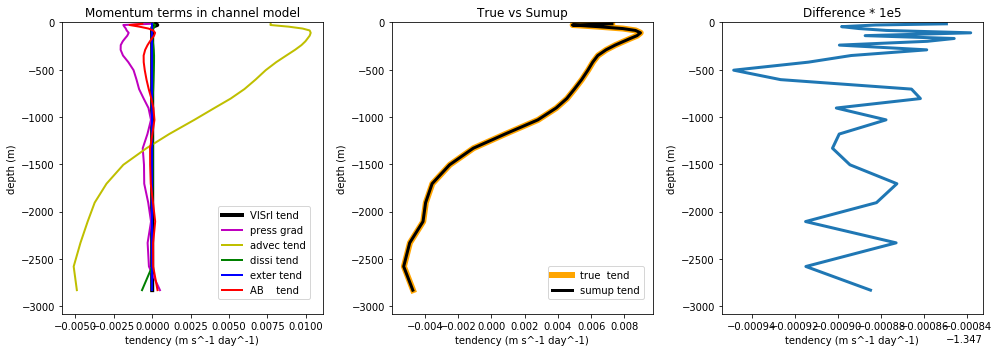

In [25]:
# plotting the vertical profile of a single point
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5))

term4.plot(ax=axes[0], linewidth=4, color='k', label='VISrI tend', y='Z')
term5.plot(ax=axes[0], linewidth=2, color='m', label='press grad', y='Z')
term2.plot(ax=axes[0], linewidth=2, color='y', label='advec tend', y='Z')
term3.plot(ax=axes[0], linewidth=2, color='g', label='dissi tend', y='Z')
term7.plot(ax=axes[0], linewidth=2, color='b', label='exter tend', y='Z')
term6.plot(ax=axes[0], linewidth=2, color='r', label='AB    tend', y='Z')

axes[0].set_ylim(dset.Z.values[29],0)
axes[0].set_xlabel('tendency (m s^-1 day^-1)')
axes[0].set_ylabel('depth (m)')
axes[0].set_title('Momentum terms in channel model')
axes[0].legend(loc=[0.6,0.05])


term1.plot(ax=axes[1], linewidth=6,color='orange',label='true  tend',y='Z')
sumup.plot(ax=axes[1], linewidth=3,color='k'    ,label='sumup tend',y='Z')

axes[1].set_ylim(dset.Z.values[29],0)
axes[1].set_xlabel('tendency (m s^-1 day^-1)')
axes[1].set_ylabel('depth (m)')
axes[1].set_title('True vs Sumup')
axes[1].legend(loc=[0.6,0.05])

((sumup-term1)*1e5).plot(ax=axes[2], linewidth=3, y='Z')

axes[2].set_ylim(dset.Z.values[29],0)
axes[2].set_xlabel('tendency (m s^-1 day^-1)')
axes[2].set_ylabel('depth (m)')
axes[2].set_title('Difference * 1e5')

plt.tight_layout()

From the above figure, we can see that momentum tendency budget is closed (exact overlap of **True tendency** and **sum-up tendency**).

#### References
1. <http://mailman.mitgcm.org/pipermail/mitgcm-devel/2019-March/007065.html>
2. <http://mailman.mitgcm.org/pipermail/mitgcm-support/2018-September/011760.html>
3. <http://mailman.mitgcm.org/pipermail/mitgcm-support/2018-January/011421.html>
4. <http://mailman.mitgcm.org/pipermail/mitgcm-support/2017-December/011400.html>
5. <http://mailman.mitgcm.org/pipermail/mitgcm-support/2017-July/011160.html>
6. <http://mailman.mitgcm.org/pipermail/mitgcm-support/2014-February/008864.html>
7. <http://mailman.mitgcm.org/pipermail/mitgcm-support/2013-December/008702.html>
8. <http://mailman.mitgcm.org/pipermail/mitgcm-support/2011-June/007258.html>
9. <http://mailman.mitgcm.org/pipermail/mitgcm-support/2010-December/006918.html>